from Mel0704E1__B4SZ224--cv9362--lb911
now 
- B0
- no random crop

# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0705A2'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0630C1' #MelPrp0630C1__crop_dark_edge_on_600data
param.ARCH = 'efficientnet-b0'


from efficientnet_pytorch import EfficientNet
param.SZ = EfficientNet.get_image_size(param.ARCH) 
# param.SZ = 348

param.EPOCHS = 80

# p2: efficientnet-b1 64
param.BS = 72

param.K=5; param.SEED=101; param.FLD2USE=0
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

# param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 8

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.EPOCHS = 5
    param.K = 5
    param.N_SAMPL = 512

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0705A2',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0630C1',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 80,
 'BS': 72,
 'K': 5,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
!nvidia-smi

Sun Jul  5 18:23:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   60C    P0    65W / 300W |   9511MiB / 16160MiB |     59%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58457, 4)


,source,im_pth,patient_id,target
24437,20,../output/MelPrp0630C1/siim-isic-melanoma-clas...,IP_4021847,0.0
57432,19,../output/MelPrp0630C1/andrewmvd--isic-2019/IS...,BCN_0004730,1.0


(58457, 4)

20    33126
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017630
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl={fld:(tr,vl) for fld,(tr,vl) in enumerate(kf.split(dftrn, groups=dftrn.patient_id))}

for fld, (tr, vl) in fld2trvl.items():
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())


0 46765 11692
1 46765 11692
2 46766 11691
3 46766 11691
4 46766 11691


0.0    0.913953
1.0    0.086047
Name: target, dtype: float64

0.0    0.911066
1.0    0.088934
Name: target, dtype: float64

0.0    0.915173
1.0    0.084827
Name: target, dtype: float64

0.0    0.91218
1.0    0.08782
Name: target, dtype: float64

0.0    0.910897
1.0    0.089103
Name: target, dtype: float64

20    26536
19    20229
Name: source, dtype: int64

20    26644
19    20121
Name: source, dtype: int64

20    26529
19    20237
Name: source, dtype: int64

20    26491
19    20275
Name: source, dtype: int64

20    26304
19    20462
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    33126
19    25331
Name: source, dtype: int64

33126

In [8]:
fld2vl20 = {}
for fld, (tr, vl) in fld2trvl.items():
    vl20 = [o for o in vl if o in idx20]
    print(len(vl), len(vl20))
    fld2vl20[fld] = vl20

11692 6590
11692 6482
11691 6597
11691 6635
11691 6822


# dataset

In [9]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if mode=='trn':
            self.composed = A.Compose([
                A.Resize(param.SZ,param.SZ),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.RandomBrightnessContrast(),
#                 A.HueSaturationValue(
#                     hue_shift_limit=10,
#                     sat_shift_limit=20,
#                     p=1),
#                 A.CLAHE(),
#                 A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
        else:
            self.composed = A.Compose([
                A.Resize(param.SZ, param.SZ),
                A.Normalize(),
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode in ('trn', 'val'):
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [10]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    dstrn = MelDataset(dftrn, mode='trn')
    print(dstrn[0][0].shape)
    plt.imshow(dstrn[0][0].permute(1, 2, 0))

# model

In [11]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [12]:
# mdl = mkmdl()

# train

## TTA

In [13]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [14]:
# Diheral TTA outside dataloader
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

def evaluate(model, dl):
    model.eval()
    prd = []
    y = []   
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        y.append(yb.cpu().detach().numpy())
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## set up model

In [15]:
mdl = mkmdl()
mdl = mdl.to(device)

if param.PRFX_B4 is not None: 
    fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.FLD2USE_B4}_best.p'
    print('load previously trained', fnm_mdl_b4)
    mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))


# opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
mdl.zero_grad()


Loaded pretrained weights for efficientnet-b0


## set up data

In [16]:
tr,vl=fld2trvl[param.FLD2USE]
vl20 =fld2vl20[param.FLD2USE]
assert set(vl20) < set(vl)
dftr=dftrn.iloc[tr]
dfvl=dftrn.iloc[vl]
dfvl20=dftrn.iloc[vl20]
ystr=dftr.target.values
ysvl=dfvl.target.values
ysvl20=dfvl20.target.values
print(len(dftr), len(dfvl), len(dfvl20))
dstr = MelDataset(dftr, mode='trn')
dsvl = MelDataset(dfvl, mode='val')
dsvl20 = MelDataset(dfvl20, mode='val')
print(len(dstr), len(dsvl), len(dsvl20))
dltr = DataLoader(dstr, batch_size=param.BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
dlvl = DataLoader(dsvl, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
dlvl20 = DataLoader(dsvl20, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltr), len(dlvl), len(dlvl20))
lendl=len(dltr)

46765 11692 6590
46765 11692 6590
650 82 46


## set up results

In [17]:
results = {}
results['fld2trvl'] = fld2trvl
results['fld2vl20'] = fld2vl20
results['param'] = param

stats = {
    'lss': {'tr':[],'vl':[],'vl20':[]},
    'scr': {'tr':[],'vl':[],'vl20':[]},
}
oof = {'y':[], 'prd':[], 'y20':[], 'prd20':[]}


def save_results():
    results['oof'] = oof
    stats['best_scr'] = best_scr
    stats['best_epc'] = best_epc
    stats['best_scr20'] = best_scr20
    stats['best_epc20'] = best_epc20
    results['stats'] = stats
    pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))

## focal loss

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

## run train

In [19]:
set_seed(param.SEED)
best_scr = float('-inf')
best_epc = -1
best_scr20 = float('-inf')
best_epc20 = -1
for epc in range(param.EPOCHS):
    prdtr_ep=[]
    ytr_ep=[]
    for step, dat in enumerate(dltr):
        mdl.train()
        xb,yb=(o.to(device) for o in dat)
        yb = yb.unsqueeze(1)
        prdb = mdl(xb)
#         loss = F.binary_cross_entropy_with_logits(prdb, yb)
        loss =  loss_fn(prdb,yb)
        if param.FP16:
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        if param.FP16:
            torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
        else:
            torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
        opt.step()
        opt.zero_grad()
        prdtr_ep.append(prdb.cpu().detach().numpy())
        ytr_ep.append(yb.cpu().detach().numpy())
        if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')
    
    prdtr_ep = np.concatenate(prdtr_ep)
    ytr_ep = np.concatenate(ytr_ep)    
    lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
    scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
    stats['lss']['tr'].append(lss_tr_ep)
    stats['scr']['tr'].append(scr_tr_ep)
    
    lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
    stats['lss']['vl'].append(lss_vl_ep)
    stats['scr']['vl'].append(scr_vl_ep)
    oof['y'].append(yvl_ep)
    oof['prd'].append(prdvl_ep)
    
    lss_vl20_ep, scr_vl20_ep, yvl20_ep, prdvl20_ep = evaluate(mdl, dlvl20)
    stats['lss']['vl20'].append(lss_vl20_ep)
    stats['scr']['vl20'].append(scr_vl20_ep)
    oof['y20'].append(yvl20_ep)
    oof['prd20'].append(prdvl20_ep)
    
    print(dtnow(), f'ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; lss_vl20 {lss_vl20_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; scr_vl20 {scr_vl20_ep:.3f}; ')
    
    if scr_vl_ep>best_scr:
        print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
        best_scr = scr_vl_ep
        best_epc = epc
        torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best.p')
    if scr_vl20_ep>best_scr20:
        print(f'better scr20 {best_scr20:.3f} -> {scr_vl20_ep:.3f}')
        best_scr20 = scr_vl20_ep
        best_epc20 = epc
        torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best20.p')
    if not param.DEBUG: torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_epc_{epc}.p')
        
    schdl.step(scr_vl_ep)  # Update learning rate schedule
    save_results()    
    

2020-07-05 18:29:26 ep 0: lss_tr 0.356; lss_vl 0.320; lss_vl20 0.217; scr_tr 0.865; scr_vl 0.914; scr_vl20 0.894; 
better scr -inf -> 0.914
better scr20 -inf -> 0.894
2020-07-05 18:35:38 ep 1: lss_tr 0.342; lss_vl 0.339; lss_vl20 0.235; scr_tr 0.892; scr_vl 0.886; scr_vl20 0.857; 
2020-07-05 18:41:59 ep 2: lss_tr 0.334; lss_vl 0.283; lss_vl20 0.166; scr_tr 0.902; scr_vl 0.922; scr_vl20 0.879; 
better scr 0.914 -> 0.922
2020-07-05 18:48:14 ep 3: lss_tr 0.325; lss_vl 0.333; lss_vl20 0.229; scr_tr 0.914; scr_vl 0.925; scr_vl20 0.881; 
better scr 0.922 -> 0.925
2020-07-05 18:54:27 ep 4: lss_tr 0.318; lss_vl 0.274; lss_vl20 0.176; scr_tr 0.921; scr_vl 0.922; scr_vl20 0.872; 
2020-07-05 19:00:39 ep 5: lss_tr 0.311; lss_vl 0.318; lss_vl20 0.225; scr_tr 0.926; scr_vl 0.920; scr_vl20 0.889; 
2020-07-05 19:06:59 ep 6: lss_tr 0.306; lss_vl 0.281; lss_vl20 0.179; scr_tr 0.932; scr_vl 0.928; scr_vl20 0.891; 
better scr 0.925 -> 0.928
2020-07-05 19:13:17 ep 7: lss_tr 0.302; lss_vl 0.275; lss_vl20 0.

KeyboardInterrupt: 

## run done

In [20]:
print(f'best_scr {best_scr:.4f}; best_epc {best_epc}; best_scr20 {best_scr20:.4f}; best_epc20 {best_epc20}')

best_scr 0.9359; best_epc 10; best_scr20 0.9143; best_epc20 8


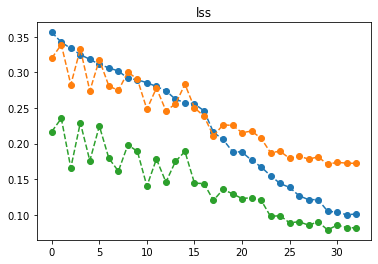

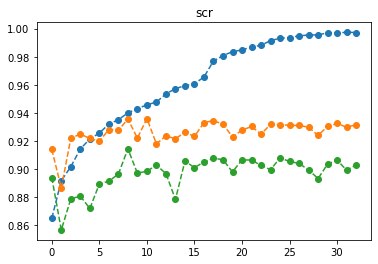

In [21]:
for mtrc in ['lss', 'scr']:
    recs=stats[mtrc]
    for tv,vs in recs.items():
        plt.title(f'{mtrc}')
        plt.plot(vs, 'o--')
    plt.show()

# inference

In [22]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0630C1/siim-isic-melanoma-clas...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0630C1/siim-isic-melanoma-clas...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0630C1/siim-isic-melanoma-clas...


10982
77


In [23]:
mdl = mkmdl()
fnm_mdl = f'{p_out}/model_{param.PRFX}_fld_{param.FLD2USE}_best20.p'
print('load model', fnm_mdl)
mdl.load_state_dict(torch.load(fnm_mdl, map_location=torch.device(DEVICE)))

mdl = mdl.to(device)

Loaded pretrained weights for efficientnet-b0
load model ../output/Mel0705A2/model_Mel0705A2_fld_0_best20.p


In [24]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    

    return prd

In [25]:
%%time
prdtst = infer(mdl, dltst)

2020-07-05 21:48:19 step 0/77
CPU times: user 51.5 s, sys: 14.9 s, total: 1min 6s
Wall time: 1min 5s


In [26]:
dfsub.target = sigmoid(prdtst)
print(dfsub.target.mean())
dfsub.head()

0.19200824201107025


,image_name,target
0,ISIC_0052060,0.075858
1,ISIC_0052349,0.047603
2,ISIC_0058510,0.060197
3,ISIC_0073313,0.049959
4,ISIC_0073502,0.230573


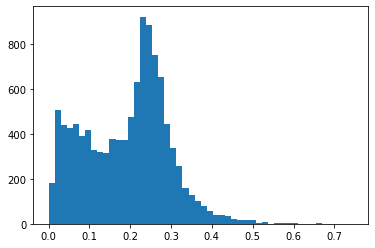

In [27]:
plt.hist(dfsub.target, bins=50);

In [28]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}.csv', index=False)

# fin

In [29]:
print(f'best_scr {best_scr:.4f}; best_epc {best_epc}; best_scr20 {best_scr20:.4f}; best_epc20 {best_epc20}')

best_scr 0.9359; best_epc 10; best_scr20 0.9143; best_epc20 8


In [30]:
param.__dict__

{'PRFX': 'Mel0705A2',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0630C1',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 80,
 'BS': 72,
 'K': 5,
 'SEED': 101,
 'FLD2USE': 0,
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [31]:
!nvidia-smi

Sun Jul  5 21:49:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   65C    P0   256W / 300W |  15447MiB / 16160MiB |     37%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  